# Setting

In [7]:
# !pip install datasets
# !pip install transformers

In [8]:
# import torch
# import pandas
# import numpy

# from transformers import pipeline
# from transformers import PerceiverModel

# from datasets import load_dataset

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 931kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 75.5kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.59MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [22]:
class Perceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, latent_size, num_classes, num_latent_blocks):
        super(Perceiver, self).__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)  # 입력을 latent 차원으로 변환
        self.cross_attention = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=8)
        self.self_attention = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=8) for _ in range(num_latent_blocks)
        ])
        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        B, T, F = x.size()  # B: Batch, T: Sequence length, F: Feature dim
        x = self.input_projection(x)  # Feature dim 변환 (F -> latent_dim)
        latents = self.latents.expand(B, -1, -1)  # Latent (batch_size, latent_size, latent_dim)
        x = x.permute(1, 0, 2)  # (T, B, latent_dim) for MultiheadAttention
        latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)
        latents, _ = self.cross_attention(latents, x, x)  # Cross Attention
        
        for layer in self.self_attention:
            latents = layer(latents)  # Latent Self-Attention
        
        latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim), Global Average Pooling
        return self.output_layer(latents)


In [23]:
import torch.optim as optim

In [24]:
model = Perceiver(input_dim=28*28, latent_dim=128, latent_size=64, num_classes=10, num_latent_blocks=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
import matplotlib.pyplot as plt

In [26]:
# Train and Test 수정
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), 1, 784)  # (batch_size, sequence_length=1, feature_dim=784)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))
        accuracy = evaluate_model(model, test_loader, log_results=False)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")
    
    return train_losses, val_accuracies

def evaluate_model(model, test_loader, log_results=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), 1, 784)  # (batch_size, sequence_length=1, feature_dim=784)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if log_results:
        print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


Epoch 1/10, Loss: 0.5742, Val Accuracy: 90.23%
Epoch 2/10, Loss: 0.3081, Val Accuracy: 93.13%
Epoch 3/10, Loss: 0.2509, Val Accuracy: 94.17%
Epoch 4/10, Loss: 0.2126, Val Accuracy: 94.26%
Epoch 5/10, Loss: 0.1949, Val Accuracy: 91.78%
Epoch 6/10, Loss: 0.1714, Val Accuracy: 95.55%
Epoch 7/10, Loss: 0.1599, Val Accuracy: 94.80%
Epoch 8/10, Loss: 0.1525, Val Accuracy: 95.76%
Epoch 9/10, Loss: 0.1349, Val Accuracy: 96.10%
Epoch 10/10, Loss: 0.1305, Val Accuracy: 94.56%


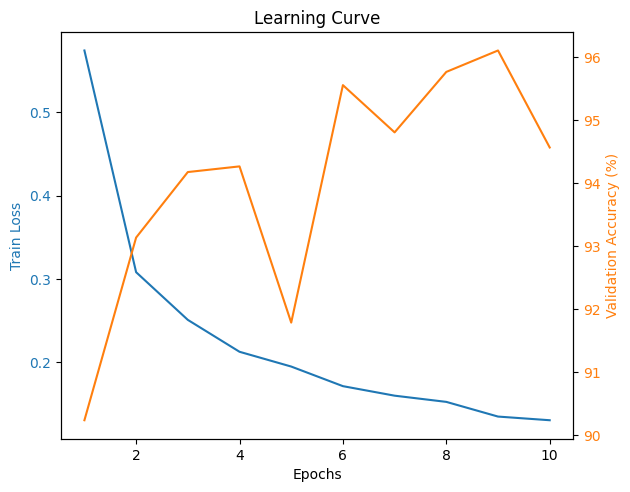

In [27]:
# 모델 학습
epochs = 10
train_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs)

# Learning curve 그리기
def plot_learning_curve(train_losses, val_accuracies):
    fig, ax1 = plt.subplots()

    # Loss curve
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss', color='tab:blue')
    ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Accuracy curve
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='tab:orange')
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Title and legend
    fig.tight_layout()
    plt.title('Learning Curve')
    plt.show()

plot_learning_curve(train_losses, val_accuracies)
